Projeto Aplicação: Classificação de Saúde Fetal

Aluno: Matheus Veloso

Turma: Mestrado/2023.1

Disciplina: Aprendizado de Máquina na Saúde

<h2>Problema</h2>

A mortalidade infantil tem sido um problema contínuo por muitas décadas nos sistemas de saúde ao redor do mundo.

O número total de óbitos fetais no Brasil entre 2015 e 2020, segundo dados do DATASUS, foi de 182.612 casos, sendo que o ano de maior ocorrência foi 2015 com 32.994

Embora tenhamos desenvolvido instrumentos que podem avaliar muitos aspectos de saúde fetal, ler e interpretar dados Cardiotocografia nem sempre é possível em regiões que falta um obstetra especialista.

Com isso, o estudo desenvolvido teve o objetivo de implementar técnicas de aprendizado de máquina, para analisar os dados da Cardiotocografia e classificar a saúde do feto em Saudável, Suspeito ou Patológico.


Base:
https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification

In [80]:
!python --version

Python 3.10.12


Importando Bibliotecas Necessárias

In [81]:
#Manipulação de dados
import pandas as pd
import numpy as np

#Visualização
import seaborn as sns
import matplotlib.pyplot as plt

#Balanceamento
from imblearn.over_sampling import SMOTE

#Modelos
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

#Avaliação
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report

In [82]:
#Montagem do drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importação da Base

In [83]:
#Importando as Bases de dados
Base = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Aprendizado de Máquina na Saúde/Projeto_Aplicacao_Fetal/fetal_health.csv', sep=',')

display(Base)

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.00,0.00,0.00,0.00,0.00,0.00,0.00,73.00,0.50,43.00,...,62.00,126.00,2.00,0.00,120.00,137.00,121.00,73.00,1.00,2.00
1,132.00,0.01,0.00,0.01,0.00,0.00,0.00,17.00,2.10,0.00,...,68.00,198.00,6.00,1.00,141.00,136.00,140.00,12.00,0.00,1.00
2,133.00,0.00,0.00,0.01,0.00,0.00,0.00,16.00,2.10,0.00,...,68.00,198.00,5.00,1.00,141.00,135.00,138.00,13.00,0.00,1.00
3,134.00,0.00,0.00,0.01,0.00,0.00,0.00,16.00,2.40,0.00,...,53.00,170.00,11.00,0.00,137.00,134.00,137.00,13.00,1.00,1.00
4,132.00,0.01,0.00,0.01,0.00,0.00,0.00,16.00,2.40,0.00,...,53.00,170.00,9.00,0.00,137.00,136.00,138.00,11.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.00,0.00,0.00,0.01,0.00,0.00,0.00,79.00,0.20,25.00,...,137.00,177.00,4.00,0.00,153.00,150.00,152.00,2.00,0.00,2.00
2122,140.00,0.00,0.00,0.01,0.00,0.00,0.00,78.00,0.40,22.00,...,103.00,169.00,6.00,0.00,152.00,148.00,151.00,3.00,1.00,2.00
2123,140.00,0.00,0.00,0.01,0.00,0.00,0.00,79.00,0.40,20.00,...,103.00,170.00,5.00,0.00,153.00,148.00,152.00,4.00,1.00,2.00
2124,140.00,0.00,0.00,0.01,0.00,0.00,0.00,78.00,0.40,27.00,...,103.00,169.00,6.00,0.00,152.00,147.00,151.00,4.00,1.00,2.00


Analise Exploratória

In [84]:
#Verificação de registros nulos
Base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [85]:
#Forço o atributo 'fetal_health' a ser inteiro
Base['fetal_health'] = Base['fetal_health'].astype(int)
Base['fetal_health']

0       2
1       1
2       1
3       1
4       1
       ..
2121    2
2122    2
2123    2
2124    2
2125    1
Name: fetal_health, Length: 2126, dtype: int64

In [86]:
#Descrição de cada atributo
Base.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.00,133.30,9.84,106.00,126.00,133.00,140.00,160.00
accelerations,2126.00,0.00,0.00,0.00,0.00,0.00,0.01,0.02
fetal_movement,2126.00,0.01,0.05,0.00,0.00,0.00,0.00,0.48
uterine_contractions,2126.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01
light_decelerations,2126.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
severe_decelerations,2126.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
prolongued_decelerations,2126.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
abnormal_short_term_variability,2126.00,46.99,17.19,12.00,32.00,49.00,61.00,87.00
mean_value_of_short_term_variability,2126.00,1.33,0.88,0.20,0.70,1.20,1.70,7.00
percentage_of_time_with_abnormal_long_term_variability,2126.00,9.85,18.40,0.00,0.00,0.00,11.00,91.00


1   77.85
2   13.88
3    8.28
Name: fetal_health, dtype: float64

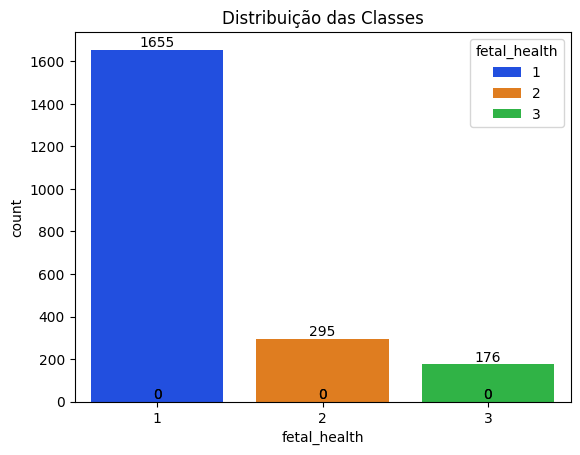

In [87]:
#Visualização da distribuição das classes
g0=sns.countplot(Base,x='fetal_health',hue='fetal_health',palette='bright',dodge=False)
g0.bar_label(g0.containers[0]);
g0.bar_label(g0.containers[1]);
g0.bar_label(g0.containers[2]);
plt.title('Distribuição das Classes')


Base['fetal_health'].value_counts(normalize=True)*100

Pré Processamento

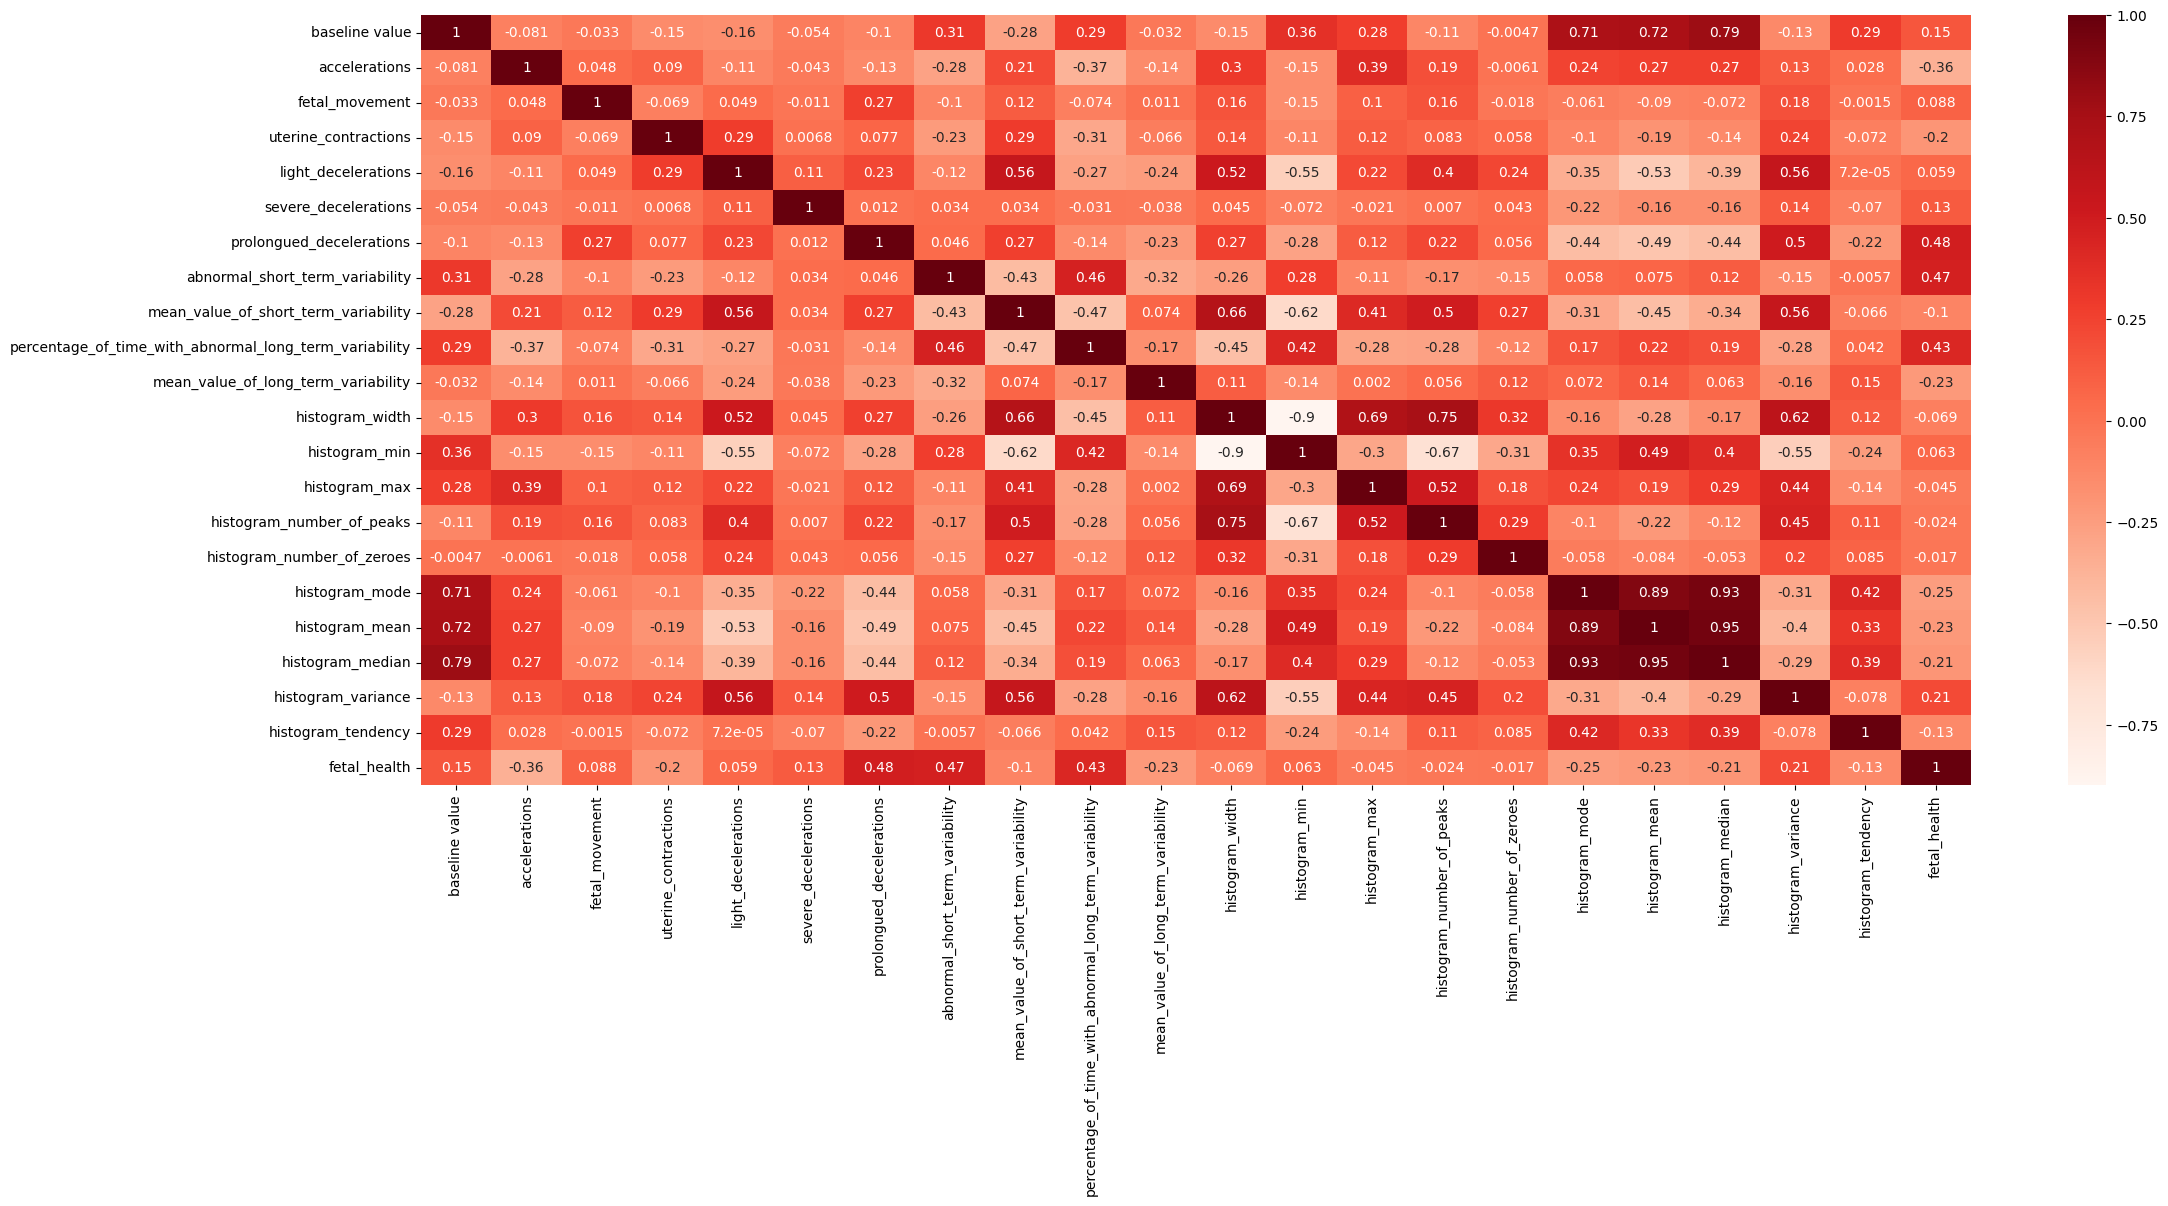

In [88]:
#Grafico de Correlação
plt.figure(figsize=(25,10))
cor = Base.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [89]:
#Filtando Atributos com correlação maior que 0.3
cor_target = abs(cor["fetal_health"])
relevant_features = cor_target[cor_target > 0.3]
relevant_features = relevant_features.index.tolist()
relevant_features

['accelerations',
 'prolongued_decelerations',
 'abnormal_short_term_variability',
 'percentage_of_time_with_abnormal_long_term_variability',
 'fetal_health']

In [90]:
#KBest- Feature
y = Base['fetal_health']
X_data = Base.drop(['fetal_health'], axis=1)


selector = SelectKBest(f_classif, k=8)
X_important = selector.fit_transform(X_data, y)
mask = selector.get_support()
important_feature_names = X_data.columns[mask]

print(important_feature_names)

Index(['accelerations', 'prolongued_decelerations',
       'abnormal_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'histogram_mode', 'histogram_mean', 'histogram_median',
       'histogram_variance'],
      dtype='object')


In [91]:
y = Base['fetal_health']

X = Base.drop(['baseline value', 'fetal_movement', 'uterine_contractions',
                       'light_decelerations', 'severe_decelerations',
                       'mean_value_of_short_term_variability',
                       'mean_value_of_long_term_variability',
                       'histogram_width',
                       'histogram_min',
                       'histogram_max', 'histogram_number_of_peaks',
                       'histogram_number_of_zeroes', 'histogram_tendency',
                       'fetal_health'],1)

In [92]:
X

,accelerations,prolongued_decelerations,abnormal_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,histogram_mode,histogram_mean,histogram_median,histogram_variance
0,0.00,0.00,73.00,43.00,120.00,137.00,121.00,73.00
1,0.01,0.00,17.00,0.00,141.00,136.00,140.00,12.00
2,0.00,0.00,16.00,0.00,141.00,135.00,138.00,13.00
3,0.00,0.00,16.00,0.00,137.00,134.00,137.00,13.00
4,0.01,0.00,16.00,0.00,137.00,136.00,138.00,11.00
...,...,...,...,...,...,...,...,...
2121,0.00,0.00,79.00,25.00,153.00,150.00,152.00,2.00
2122,0.00,0.00,78.00,22.00,152.00,148.00,151.00,3.00
2123,0.00,0.00,79.00,20.00,153.00,148.00,152.00,4.00
2124,0.00,0.00,78.00,27.00,152.00,147.00,151.00,4.00


Separação da base de teste e treino

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Balanceamento - Oversampling - SMOTE

[   0 1242  213  139]
[   0 1242 1242 1242]


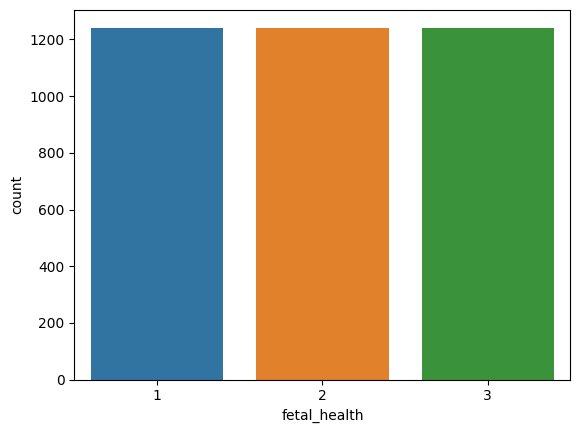

In [94]:
smt = SMOTE()

X_train_balanced, y_train_balanced = smt.fit_resample(X_train, y_train)

#Contagem da base de treino
print(np.bincount(y_train))

#Contagem da base de treino balanceada
print(np.bincount(y_train_balanced))

#Plot
ax = sns.countplot(x=y_train_balanced)

#Recebe os dados balanceados
X_train = X_train_balanced
y_train = y_train_balanced

KNN

              precision    recall  f1-score   support

           1       0.96      0.90      0.93       413
           2       0.63      0.79      0.70        82
           3       0.82      0.86      0.84        37

    accuracy                           0.88       532
   macro avg       0.80      0.85      0.82       532
weighted avg       0.90      0.88      0.89       532

Accuracy: 0.8834586466165414


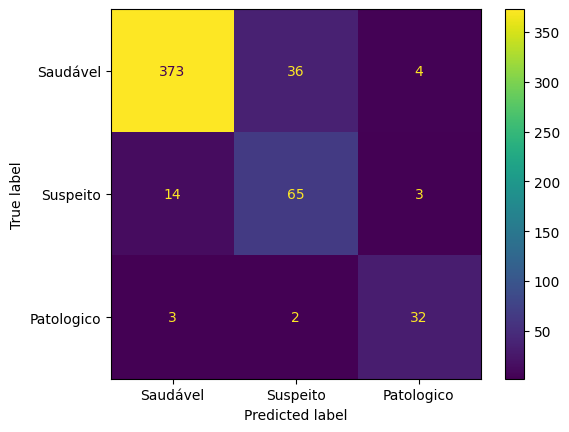

In [95]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Calcula Acurácia
accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test,y_pred))
print("Accuracy:", accuracy)

#Matriz confusão KNN
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels = ["Saudável", "Suspeito", "Patologico"]).plot()
plt.grid(False)
plt.show()

Decision Tree

              precision    recall  f1-score   support

           1       0.96      0.95      0.95       413
           2       0.78      0.77      0.77        82
           3       0.86      0.97      0.91        37

    accuracy                           0.92       532
   macro avg       0.86      0.90      0.88       532
weighted avg       0.92      0.92      0.92       532

Accuracy: 0.9210526315789473


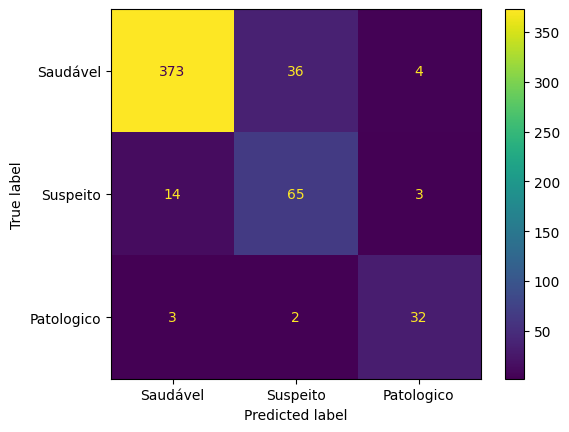

In [96]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred_dtc = dtc.predict(X_test)

# Calcula acurácia
accuracy = accuracy_score(y_test, y_pred_dtc)
print(classification_report(y_test,y_pred_dtc))
print("Accuracy:", accuracy)

#Matriz confusão Arvore de Decisão
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels = ["Saudável", "Suspeito", "Patologico"]).plot()
plt.grid(False)
plt.show()

Random Forest


Processed Dataset Accuracy: 0.9492481203007519
              precision    recall  f1-score   support

           1       0.98      0.96      0.97       413
           2       0.85      0.88      0.86        82
           3       0.84      0.97      0.90        37

    accuracy                           0.95       532
   macro avg       0.89      0.94      0.91       532
weighted avg       0.95      0.95      0.95       532



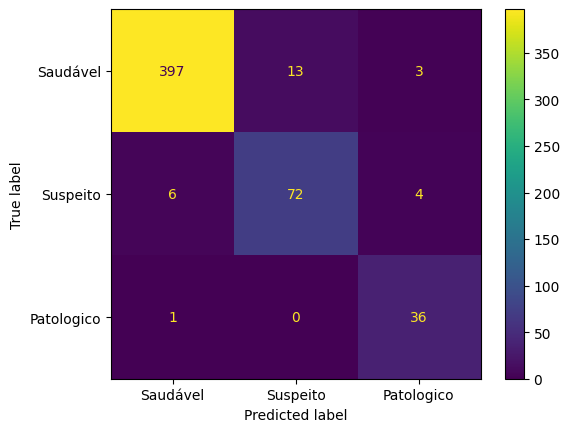

In [97]:
# Using processed dataset
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f"Processed Dataset Accuracy: {accuracy_score(y_test, y_pred)}")

print(classification_report(y_test, y_pred))

#Matriz confusão Floresta Aleatoria
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels = ["Saudável", "Suspeito", "Patologico"]).plot()
plt.grid(False)
plt.show()

              precision    recall  f1-score   support

           1       0.98      0.96      0.97       413
           2       0.85      0.89      0.87        82
           3       0.92      0.97      0.95        37

    accuracy                           0.95       532
   macro avg       0.92      0.94      0.93       532
weighted avg       0.95      0.95      0.95       532



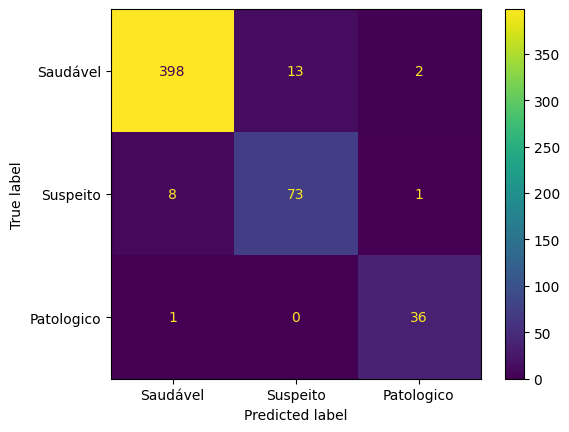

In [98]:
# Criar o modelo LGBMClassifier
LGBM = LGBMClassifier()

# Treinar o modelo
LGBM.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = LGBM.predict(X_test)

print(classification_report(y_test, y_pred))

#Matriz confusão Arvore de Decisão
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels = ["Saudável", "Suspeito", "Patologico"]).plot()
plt.grid(False)
plt.show()

In [99]:
pip install lazypredict

In [ ]:
from lazypredict.Supervised import LazyClassifier

# Criar o modelo LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Treinar e avaliar o modelo
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Exibir as métricas de desempenho dos modelos
print(models)

 90%|████████▉ | 26/29 [00:09<00:01,  2.97it/s]

Conclusão:

Entre os Modelos de classificação utilizados o LGBMClassifier se mostrou mais competitivo, visto que obteve melhores números nas principais metricas de avaliação: Acurácia, Precisão e Sensibilidade.

Visto os resultados, o uso de aprendizado de máquina para classificar a saúde fetal mostrou que é ferramenta eficiente e benéfica para apoiar especialistas em saúde.

